<a href="https://colab.research.google.com/github/pjchickey/RACOON/blob/Angel/Algorithm/RACOON_Testing_TFLite_mode2l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [2]:
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 3.8MB 52.7MB/s 
     |████████████████████████████████| 450kB 60.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=a907bb54d25d52c23a4e77f899c9d6bce579ebc9799da25bf3fc688430d96a3b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [4]:
import pandas as pd

pd.set_option("display.precision", 8)

In [5]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Hub version:  0.10.0
Eager mode:  True
GPU is available


# Transfer Learning

In [61]:
data_root = '/content/drive/MyDrive/Images-resized'

In [62]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 61 images belonging to 6 classes.
Found 263 images belonging to 6 classes.


In [63]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 6)


In [64]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Cardboard' 'Glass' 'Metal' 'Paper' 'Plastic' 'Trash']


In [65]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [66]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [67]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Train for 9.0 steps, validate for 2.0 steps
Epoch 1/10
9/9 [==============================] - 6s 624ms/step - loss: 2.0703 - acc: 0.2471 - val_loss: 1.5711 - val_acc: 0.4098
Epoch 2/10
9/9 [==============================] - 2s 183ms/step - loss: 1.5726 - acc: 0.3916 - val_loss: 1.4290 - val_acc: 0.4918
Epoch 3/10
9/9 [==============================] - 2s 180ms/step - loss: 1.3243 - acc: 0.4981 - val_loss: 1.4035 - val_acc: 0.5082
Epoch 4/10
9/9 [==============================] - 2s 180ms/step - loss: 1.0445 - acc: 0.5970 - val_loss: 1.3931 - val_acc: 0.6393
Epoch 5/10
9/9 [==============================] - 2s 180ms/step - loss: 0.9365 - acc: 0.6008 - val_loss: 1.4142 - val_acc: 0.5738
Epoch 6/10
9/9 [==============================] - 2s 182ms/step - loss: 0.7347 - acc: 0.6996 - val_loss: 1.3903 - val_acc: 0.6230
Epoch 7/10
9/9 [==============================] - 2s 183ms/step - loss: 0.6879 - acc: 0.7452 - val_loss: 1.3862 - val_acc: 0.6066
Epoch 8/10
9/9 [==============================

In [68]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

2/2 [==============================] - 0s 152ms/step - loss: 1.4099 - acc: 0.6066


In [69]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 1.41
Final accuracy: 60.66%


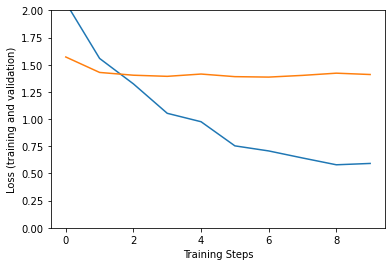

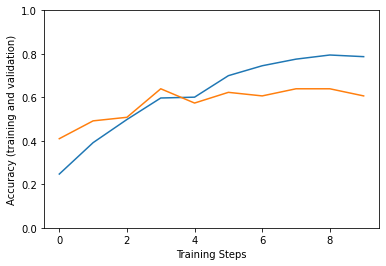

In [70]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

# Save and load model

In [71]:
RACOON_SAVED_MODEL = "saved_models/racoon"
tf.saved_model.save(model, RACOON_SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/racoon/assets


INFO:tensorflow:Assets written to: saved_models/racoon/assets


In [72]:
# Load SavedModel

racoon_model = hub.load(RACOON_SAVED_MODEL)
print(racoon_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f5876044cf8>


In [73]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [74]:
tf_model_predictions = racoon_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 6)


In [75]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Cardboard,Glass,Metal,Paper,Plastic,Trash
0,0.01989508,0.02741815,0.00221365,0.00902627,0.40609336,0.53535348
1,0.80348891,0.01094684,0.03756991,0.11265707,0.02912087,0.00621649
2,0.00233120,0.15129228,0.80357850,0.00042204,0.03885263,0.00352332
3,0.07151743,0.21250388,0.00387737,0.12642537,0.22552773,0.36014813
4,0.14361444,0.09118959,0.01138219,0.24576075,0.34873274,0.15932025


In [76]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

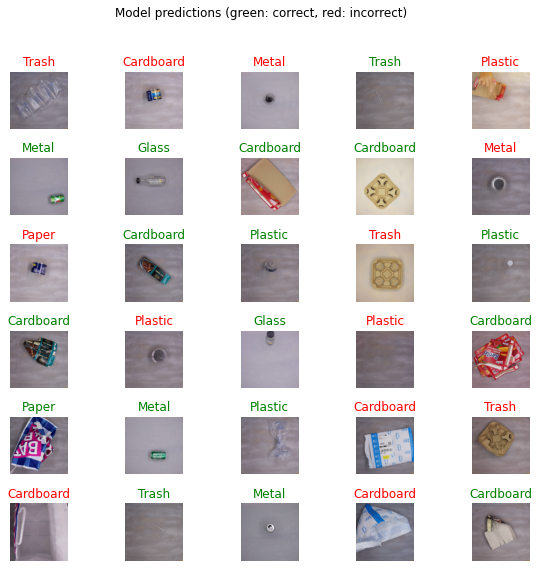

In [77]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Convert model to TFLite

In [78]:
!mkdir "tflite_models"

mkdir: cannot create directory ‘tflite_models’: File exists


In [79]:
TFLITE_MODEL = "tflite_models/racoon.tflite"

In [80]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : racoon_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 8.6M
-rw-r--r-- 1 root root 8.6M Dec  1 07:56 racoon.tflite


In [81]:
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 6]
type: <class 'numpy.float32'>


In [82]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 13))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  6]
type: <class 'numpy.float32'>


In [83]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 6)


In [84]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,Cardboard,Glass,Metal,Paper,Plastic,Trash
0,0.01989535,0.02741872,0.00221367,0.00902648,0.40609369,0.53535211
1,0.80348730,0.01094691,0.03757029,0.11265814,0.02912099,0.00621654
2,0.00233122,0.15129383,0.80357611,0.00042204,0.03885343,0.00352332
3,0.07151748,0.21250360,0.00387736,0.12642570,0.22552843,0.36014748
4,0.14361405,0.09118935,0.01138221,0.24576025,0.34873289,0.15932119


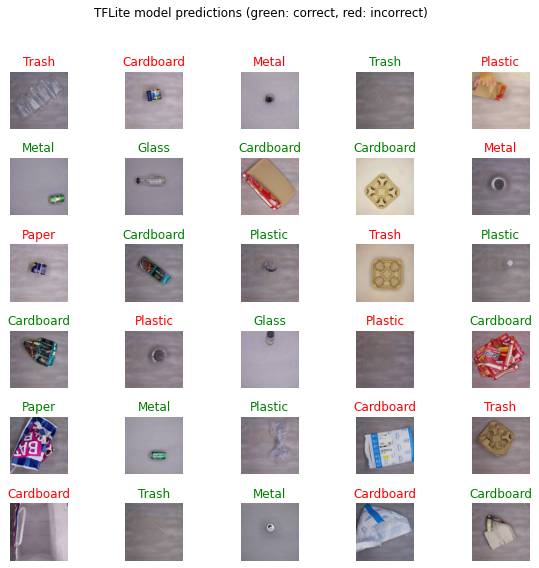

In [85]:
# Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")